# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
35242,68234514,Deputy Manager Cafe Rouge Sherwood Center Parcs,Deputy Manager Cafe Rouge Sherwood Center Pa...,"Newark, Nottinghamshire Nottinghamshire East M...",Newark,NaN,NaN,Cafe Rouge,Hospitality & Catering Jobs,20k to 22k per year GBP,21000,caterer.com,9.952325
180142,71566420,"SQL Server Developer SSIS, SSRS and SSAS",SQL Server Technical Lead Developer/Team Leade...,Egham Surrey South East,Egham,NaN,permanent,Spargonet Consulting Plc,IT Jobs,"50000 to 55000 per annum - Pension, Life Assur...",52500,cwjobs.co.uk,10.868587
154967,71037298,Water Treatment Plant / Equipment Engineer,Our client is one of the UK's leading independ...,London,London,full_time,permanent,W5 Recruitment,Engineering Jobs,"From 25,000 to 35,000 per year",30000,JustLondonJobs,10.308986


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
from collections import Counter
from functools import reduce
from itertools import chain

# Count how many times does each token occur in "Title" and "FullDescription"
tokens = chain.from_iterable(map(str.split, chain(data["Title"], data["FullDescription"])))
token_counts = Counter(tokens)

In [7]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

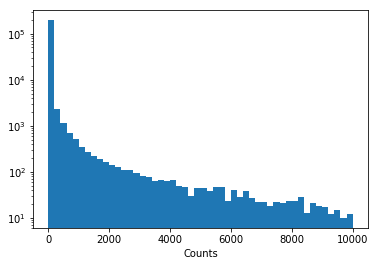

In [8]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= 10]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [11]:
token_to_id = {token: id for id, token in enumerate(tokens)}

In [12]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [13]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [14]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [15]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [17]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [18]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 176,   88,   11,   88,  321,  262, 1569,  263],
        [1720, 1907,  173,  174,    1,    1,    1,    1],
        [3094,   88,   15, 1308, 1471,  321,    0,    1]], dtype=int32),
 'FullDescription': array([[1824,  477,   57, 3162, 1373, 5371,  120, 1442,   15,  142],
        [  60,    6,  242,   38,    6, 1719,   63, 1720,   64,   74],
        [3094,   88,   15,  101, 1563,   88,   15, 1308, 1471,   15]],
       dtype=int32),
 'Categorical': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.768506, 10.819798, 11.002116], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [19]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [20]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = torch.relu(h)
        h = self.dense(h)
        
        return h

In [21]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [22]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.block = nn.Sequential(
            nn.Conv1d(64, out_size, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv1d(out_size, 2 * out_size, kernel_size=3, padding=1),
            GlobalMaxPooling(),
            nn.ReLU(True),
            nn.Linear(2 * out_size, out_size)
        )

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.block(h)
        
        return h

In [23]:
desc_encoder = DescriptionEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [24]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=128)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 64),
            nn.ReLU(True),
            nn.Linear(64, 64)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.head = nn.Sequential(
            nn.Linear(64 + 128 + 64, 128),
            nn.ReLU(True),
            nn.Linear(128, 1),
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        h = self.head(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return h[:, 0]

In [25]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [27]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [28]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [29]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [30]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [31]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:



	Loss:	8.12162
	MAE:	42602.72809



Validation:



	Loss:	0.31221
	MAE:	5091.31087



Training:



	Loss:	0.26070
	MAE:	4950.08861



Validation:



	Loss:	0.24399
	MAE:	4955.50015



Training:



	Loss:	0.21063
	MAE:	4339.52545



Validation:



	Loss:	0.17655
	MAE:	3948.71297



Training:



	Loss:	0.18193
	MAE:	4015.28217



Validation:



	Loss:	0.15821
	MAE:	3713.60731



Training:



	Loss:	0.16055
	MAE:	3824.08833



Validation:



	Loss:	0.14463
	MAE:	3571.08336



Training:



	Loss:	0.15419
	MAE:	3792.86222



Validation:



	Loss:	0.19071
	MAE:	3939.30953



Training:



	Loss:	0.15317
	MAE:	3762.67599



Validation:



	Loss:	0.14133
	MAE:	3708.06109



Training:



	Loss:	0.13286
	MAE:	3514.55081



Validation:



	Loss:	0.12754
	MAE:	3329.88466



Training:



	Loss:	0.13271
	MAE:	3401.35654



Validation:



	Loss:	0.16533
	MAE:	4314.90828



Training:



	Loss:	0.13853
	MAE:	3475.31527



Validation:



	Loss:	0.11669
	MAE:	3208.07799



Training:



	Loss:	0.11899
	MAE:	3318.38450



Validation:



	Loss:	0.11875
	MAE:	3205.26429



Training:



	Loss:	0.13820
	MAE:	3617.94687



Validation:



	Loss:	0.17963
	MAE:	3891.44898



Training:



	Loss:	0.12616
	MAE:	3447.19806



Validation:



	Loss:	0.10687
	MAE:	3070.30930



Training:



	Loss:	0.10507
	MAE:	3084.58800



Validation:



	Loss:	0.11555
	MAE:	3163.72697



Training:



	Loss:	0.11075
	MAE:	3150.49259



Validation:



	Loss:	0.10372
	MAE:	3020.92815



Training:



	Loss:	0.10747
	MAE:	3086.35136



Validation:



	Loss:	0.10228
	MAE:	2991.27993



Training:



	Loss:	0.12317
	MAE:	3488.01820



Validation:



	Loss:	0.13337
	MAE:	3412.66928



Training:



	Loss:	0.10933
	MAE:	3187.85350



Validation:



	Loss:	0.09568
	MAE:	2918.21750



Training:



	Loss:	0.10384
	MAE:	3156.57339



Validation:



	Loss:	0.10314
	MAE:	3017.15121



Training:



	Loss:	0.10285
	MAE:	3115.74563



Validation:



	Loss:	0.12166
	MAE:	3299.11397



Training:



	Loss:	0.11320
	MAE:	3150.34553



Validation:



	Loss:	0.09535
	MAE:	2904.13261



Training:



	Loss:	0.12602
	MAE:	3415.60504



Validation:



	Loss:	0.18715
	MAE:	5015.36000



Training:



	Loss:	0.09552
	MAE:	3056.70944



Validation:



	Loss:	0.14629
	MAE:	4149.60055



Training:



	Loss:	0.11049
	MAE:	3234.28453



Validation:



	Loss:	0.13777
	MAE:	3476.21685



Training:



	Loss:	0.09635
	MAE:	3003.77150



Validation:



	Loss:	0.08767
	MAE:	2822.78636



Training:



	Loss:	0.10360
	MAE:	3065.44480



Validation:



	Loss:	0.08918
	MAE:	2830.23005



Training:



	Loss:	0.11518
	MAE:	3277.77439



Validation:



	Loss:	0.10720
	MAE:	3325.50378



Training:



	Loss:	0.12323
	MAE:	3403.98160



Validation:



	Loss:	0.09170
	MAE:	2845.31026



Training:



	Loss:	0.12974
	MAE:	3526.73906



Validation:



	Loss:	0.09294
	MAE:	2851.36802



Training:



	Loss:	0.10352
	MAE:	3101.57739



Validation:



	Loss:	0.08871
	MAE:	2819.22523



Training:



	Loss:	0.08770
	MAE:	2902.49168



Validation:



	Loss:	0.11302
	MAE:	3134.36626



Training:



	Loss:	0.09699
	MAE:	3035.18540



Validation:



	Loss:	0.09282
	MAE:	3026.43507



Training:



	Loss:	0.09865
	MAE:	3143.83264



Validation:



	Loss:	0.09199
	MAE:	2847.02748



Training:



	Loss:	0.09218
	MAE:	2922.52913



Validation:



	Loss:	0.09613
	MAE:	3073.54835



Training:



	Loss:	0.09356
	MAE:	2953.89374



Validation:



	Loss:	0.15519
	MAE:	3739.83983



Training:



	Loss:	0.10530
	MAE:	3098.56353



Validation:



	Loss:	0.08788
	MAE:	2908.65853



Training:



	Loss:	0.09069
	MAE:	2893.24910



Validation:



	Loss:	0.08724
	MAE:	2902.56838



Training:



	Loss:	0.08885
	MAE:	2867.60647



Validation:



	Loss:	0.07959
	MAE:	2691.11725



Training:



	Loss:	0.09834
	MAE:	3056.51284



Validation:



	Loss:	0.10851
	MAE:	3151.49457



Training:



	Loss:	0.08190
	MAE:	2770.51663



Validation:



	Loss:	0.08178
	MAE:	2703.93025



Training:



	Loss:	0.09530
	MAE:	3009.73296



Validation:



	Loss:	0.08973
	MAE:	2972.67751



Training:



	Loss:	0.08638
	MAE:	2823.20973



Validation:



	Loss:	0.09095
	MAE:	2984.48819



Training:



	Loss:	0.10266
	MAE:	3100.53150



Validation:



	Loss:	0.13949
	MAE:	4089.37450



Training:



	Loss:	0.09357
	MAE:	2946.51843



Validation:



	Loss:	0.12006
	MAE:	3649.88181



Training:



	Loss:	0.09190
	MAE:	2939.59067



Validation:



	Loss:	0.08284
	MAE:	2818.04670



Training:



	Loss:	0.09153
	MAE:	2916.98339



Validation:



	Loss:	0.09178
	MAE:	2859.83323



Training:



	Loss:	0.09041
	MAE:	2880.75790



Validation:



	Loss:	0.08220
	MAE:	2699.76420



Training:



	Loss:	0.08524
	MAE:	2822.90190



Validation:



	Loss:	0.07513
	MAE:	2610.60993



Training:



	Loss:	0.08250
	MAE:	2737.69692



Validation:



	Loss:	0.10663
	MAE:	3329.29685



Training:



	Loss:	0.08930
	MAE:	2897.18021



Validation:



	Loss:	0.19204
	MAE:	5362.74833



Training:



	Loss:	0.09650
	MAE:	3006.71274



Validation:



	Loss:	0.13688
	MAE:	3489.77113



Training:



	Loss:	0.09179
	MAE:	2949.80517



Validation:



	Loss:	0.08339
	MAE:	2822.92616



Training:



	Loss:	0.09741
	MAE:	3071.39533



Validation:



	Loss:	0.10047
	MAE:	2965.49427



Training:



	Loss:	0.09180
	MAE:	2917.98715



Validation:



	Loss:	0.07730
	MAE:	2638.12941



Training:



	Loss:	0.10436
	MAE:	3085.55346



Validation:



	Loss:	0.07929
	MAE:	2665.41514



Training:



	Loss:	0.10437
	MAE:	3145.21555



Validation:



	Loss:	0.08592
	MAE:	2894.61219



Training:



	Loss:	0.09125
	MAE:	2960.22451



Validation:



	Loss:	0.07477
	MAE:	2597.37423



Training:



	Loss:	0.11052
	MAE:	3253.79193



Validation:



	Loss:	0.08601
	MAE:	2748.36641



Training:



	Loss:	0.10052
	MAE:	3055.00584



Validation:



	Loss:	0.07790
	MAE:	2694.52021



Training:



	Loss:	0.08686
	MAE:	2833.43078



Validation:



	Loss:	0.07341
	MAE:	2572.87011



Training:



	Loss:	0.08299
	MAE:	2748.21605



Validation:



	Loss:	0.10739
	MAE:	3062.00002



Training:



	Loss:	0.08215
	MAE:	2795.90201



Validation:



	Loss:	0.08955
	MAE:	2983.69715



Training:



	Loss:	0.09046
	MAE:	2923.53498



Validation:



	Loss:	0.07413
	MAE:	2582.44588



Training:



	Loss:	0.08923
	MAE:	2892.11064



Validation:



	Loss:	0.09050
	MAE:	3007.46212



Training:



	Loss:	0.08745
	MAE:	2914.14470



Validation:



	Loss:	0.07477
	MAE:	2577.89013



Training:



	Loss:	0.08242
	MAE:	2813.34604



Validation:



	Loss:	0.08556
	MAE:	2900.53270



Training:



	Loss:	0.08052
	MAE:	2819.19329



Validation:



	Loss:	0.07295
	MAE:	2588.88826



Training:



	Loss:	0.07469
	MAE:	2564.55524



Validation:



	Loss:	0.07213
	MAE:	2542.07987



Training:



	Loss:	0.08309
	MAE:	2754.82745



Validation:



	Loss:	0.07604
	MAE:	2672.72825



Training:



	Loss:	0.08161
	MAE:	2750.95591



Validation:



	Loss:	0.08061
	MAE:	2788.76115



Training:



	Loss:	0.08682
	MAE:	2751.28937



Validation:



	Loss:	0.08883
	MAE:	2827.16262



Training:



	Loss:	0.07685
	MAE:	2678.94743



Validation:



	Loss:	0.14257
	MAE:	3550.91963



Training:



	Loss:	0.07626
	MAE:	2650.79930



Validation:



	Loss:	0.12139
	MAE:	3298.59495



Training:



	Loss:	0.08539
	MAE:	2856.77289



Validation:



	Loss:	0.07854
	MAE:	2622.49244



Training:



	Loss:	0.09169
	MAE:	2967.17941



Validation:



	Loss:	0.15179
	MAE:	4475.99899



Training:



	Loss:	0.08626
	MAE:	2816.12451



Validation:



	Loss:	0.07641
	MAE:	2610.23976



Training:



	Loss:	0.07264
	MAE:	2612.54761



Validation:



	Loss:	0.07223
	MAE:	2528.89263



Training:



	Loss:	0.07980
	MAE:	2690.47257



Validation:



	Loss:	0.07153
	MAE:	2524.39389



Training:



	Loss:	0.07490
	MAE:	2604.19380



Validation:



	Loss:	0.08432
	MAE:	2704.41298



Training:



	Loss:	0.09389
	MAE:	2998.13444



Validation:



	Loss:	0.07094
	MAE:	2511.02247



Training:



	Loss:	0.06948
	MAE:	2456.75445



Validation:



	Loss:	0.11206
	MAE:	3174.94269



Training:



	Loss:	0.08996
	MAE:	2942.31975



Validation:



	Loss:	0.07751
	MAE:	2743.61336



Training:



	Loss:	0.07697
	MAE:	2745.55156



Validation:



	Loss:	0.07066
	MAE:	2512.67335



Training:



	Loss:	0.07308
	MAE:	2578.48449



Validation:



	Loss:	0.06948
	MAE:	2496.51200



Training:



	Loss:	0.08735
	MAE:	2881.29858



Validation:



	Loss:	0.06873
	MAE:	2477.51748



Training:



	Loss:	0.07019
	MAE:	2506.08380



Validation:



	Loss:	0.07118
	MAE:	2548.24847



Training:



	Loss:	0.07545
	MAE:	2657.26171



Validation:



	Loss:	0.06969
	MAE:	2510.31254



Training:



	Loss:	0.07753
	MAE:	2735.73410



Validation:



	Loss:	0.07756
	MAE:	2618.17182



Training:



	Loss:	0.07520
	MAE:	2668.21948



Validation:



	Loss:	0.08758
	MAE:	2781.81339



Training:



	Loss:	0.07332
	MAE:	2671.77235



Validation:



	Loss:	0.09711
	MAE:	2943.64362



Training:



	Loss:	0.07265
	MAE:	2608.61484



Validation:



	Loss:	0.06905
	MAE:	2483.55210



Training:



	Loss:	0.06391
	MAE:	2365.39011



Validation:



	Loss:	0.06876
	MAE:	2486.45521



Training:



	Loss:	0.07032
	MAE:	2578.92616



Validation:



	Loss:	0.10751
	MAE:	3463.24022



Training:



	Loss:	0.08436
	MAE:	2894.72401



Validation:



	Loss:	0.07928
	MAE:	2658.43212



Training:



	Loss:	0.06815
	MAE:	2471.21388



Validation:



	Loss:	0.08195
	MAE:	2839.76534



Training:



	Loss:	0.07938
	MAE:	2737.18181



Validation:



	Loss:	0.07800
	MAE:	2644.74689



Training:



	Loss:	0.08150
	MAE:	2650.66851



Validation:



	Loss:	0.08098
	MAE:	2844.61800



Training:



	Loss:	0.07008
	MAE:	2604.22644



Validation:



	Loss:	0.07817
	MAE:	2622.41475



Training:



	Loss:	0.07563
	MAE:	2654.60435



Validation:



	Loss:	0.07134
	MAE:	2504.86233



Training:



	Loss:	0.07336
	MAE:	2603.59411



Validation:



	Loss:	0.09536
	MAE:	3205.72325





In [32]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()
    val_mae += compute_mae(reference, prediction).data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.09536
	MAE:	3205.72325





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [60]:
def make_tensors(sample):
    title_ix = torch.tensor(as_matrix([sample["Title"]]), dtype=torch.int64)
    desc_ix = torch.tensor(as_matrix([sample["FullDescription"]]), dtype=torch.int64)
    cat_features = torch.tensor(
        categorical_vectorizer.transform([dict(sample[categorical_columns])]), dtype=torch.float32)
    
    return title_ix, desc_ix, cat_features

def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    
    # compute model prediction on sample (scalar float log-salary)
    baseline_pred = model(*make_tensors(sample))[0].data.numpy()
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    tokens = sample[col_name].split()

    sample = sample.copy()
    predictions_without_word = []
    
    for idx, token in enumerate(tokens):
        curr_tokens = tokens.copy()
        curr_tokens[idx] = UNK
        sample[col_name] = ' '.join(curr_tokens)
        predictions_without_word.append(model(*make_tensors(sample)).data.numpy())
    
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    
    # return a list of pairs: [(token, score_difference)]
    return list(zip(tokens, score_differences))

In [61]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: Id                                                             71125617
Title                                                     sales manager
FullDescription       position : sales manager location : cambridges...
LocationRaw                                              Cambridgeshire
LocationNormalized                                       Cambridgeshire
ContractType                                                        NaN
ContractTime                                                  permanent
Company                                                           Other
Category                                               Engineering Jobs
SalaryRaw             40000 - 60000/annum Commission Scheme + Car + ...
SalaryNormalized                                                  50000
SourceName                                             cv-library.co.uk
Log1pSalary                                                     10.8198
Name: 157979, dtype: object
[('sales', array([-0.09016037

In [100]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % tuple(rgba[0][:3])
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [101]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
print("Salary (gbp):", model(*make_tensors(sample))[0])

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 12890
Salary (gbp): tensor(9.7454, grad_fn=<SelectBackward>)


payroll officer

my client requires and experienced payroll officer to join their busy team covering long term sickness . this role will be for a period of at least six months sound experience is payroll is required . the successful candidate must be available from the end of february and come from an accounts background . parking available . working hours ****:**** based in the worcestershire area .

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...